This notebook is aimed at summarzing the BUSCO results of different Pst assemblies and plotting it out in a good way.


This notebook was only designed for the purpose of analyzing the Pst-104E genome. No gurantees it works in any other situtation. It will have spelling errors due to the lack of autocorrection.

Busco analysis for all protein data sets was run on the command line using busco2 v2.0 4 beta. In all cases we ran busco2 in the protein mode using the basidiomycota reference database downloaded 01/09/2016 (-l basidiomycota_odb9 -m protein)!

In [1]:
%matplotlib inline

In [2]:
import os
from Bio import SeqIO
import pandas as pd
import re
from pybedtools import BedTool
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
#import rcParams and make it outfit also when saving files
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

In [6]:
#define base folders
BUSCO_BASE_FOLDER = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/busco/Pst_104E_v12'
FIGURE_FOLDER = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/figures'

In [7]:
#first sort out the combined BUSCO of p and h
#read in the data form the primary contig analysis
fn_p = os.path.join(BUSCO_BASE_FOLDER, 'run_Pst_104E_v12_p_ctg.anno.protein.fa.protein')
busco_header = ['busco', 'status', 'protein_ID', 'Score', 'Length']
Busco_p = pd.read_csv(os.path.join(fn_p, 'full_table_Pst_104E_v12_p_ctg.anno.protein.fa.protein.tsv'),\
                     header=None, names=busco_header, sep='\t', comment='#')

Complete_busco_p = Busco_p

In [8]:
#first sort out the combined BUSCO of p and h
#read in the data form the haplotig analysis
fn_h = os.path.join(BUSCO_BASE_FOLDER, 'run_Pst_104E_v12_h_ctg.anno.protein.fa.protein')
Busco_h = pd.read_csv(os.path.join(fn_h, 'full_table_Pst_104E_v12_h_ctg.anno.protein.fa.protein.tsv'),\
                     header=None, names=busco_header, sep='\t', comment='#')
Complete_busco_h = Busco_h

In [9]:
#check for Buscos that are missing or fragmented in p
m_or_f_in_p = Complete_busco_p[(Complete_busco_p.status == 'Missing') \
                               | (Complete_busco_p.status == 'Fragmented')]

In [11]:
#get all h buscos that are missing in p
p_missing_replaced = Complete_busco_h[(Complete_busco_h.busco.isin(Complete_busco_p[(Complete_busco_p.status == 'Missing')]['busco']))\
                &(Complete_busco_h.status != 'Missing')]

In [13]:
#get all h buscos that are fragmented in p and not Missing or Fragmented in h
p_fragmented_replaced = Complete_busco_h[(Complete_busco_h.busco.isin(\
                        Complete_busco_p[(Complete_busco_p.status == 'Fragmented')]['busco']))\
                &(Complete_busco_h.status != 'Missing')&(Complete_busco_h.status != 'Fragmented')]

In [61]:
#now remove all the buscos that will be replaced
Fixed_total_busco = Complete_busco_p[(~Complete_busco_p.busco.isin(p_missing_replaced.busco.append(p_fragmented_replaced.busco)))].copy()


In [62]:
Fixed_total_busco = pd.concat([Fixed_total_busco, p_missing_replaced, p_fragmented_replaced])

In [63]:
#drop the duplicates as this interfers with the counting and representation at the end
Pst_104E_ph  = Fixed_total_busco.drop_duplicates(subset='busco').groupby('status')['busco'].count()

In [68]:
#the sum should be the total amount of searched buscos for odb9 thats 1335
Pst_104E_ph.sum()

1335

In [69]:
total_buscos = Pst_104E_ph['Complete'] + Pst_104E_ph['Duplicated']
total_buscos = pd.Series([total_buscos], name='total_buscos')

In [70]:
Pst_104E_ph = Pst_104E_ph.append(total_buscos).reset_index(drop=True)

In [71]:
total_buscos 

0    1292
Name: total_buscos, dtype: int64

In [72]:
busco_index = ['Complete and single-copy BUSCOs', 'Complete and duplicated BUSCOs', 'Fragmented BUSCOs', 'Missing BUSCOs', 'Complete BUSCOs']

In [73]:
Pst_104E_ph.index = busco_index

In [74]:
Pst_104E_ph

Complete and single-copy BUSCOs    1145
Complete and duplicated BUSCOs      147
Fragmented BUSCOs                    24
Missing BUSCOs                       19
Complete BUSCOs                    1292
dtype: int64

In [75]:
#these were done on the command line and transfered manually. In know I know I could have
#written a parser
Pst_104E_p = pd.Series([1121, 133, 48, 33, 1254], index= busco_index)
Pst_104E_h = pd.Series([1052,93,42,148,1145], index= busco_index)
Pst_78 = pd.Series([1135, 141,40,19,1276], index= busco_index)
Pst_130 = pd.Series([1005, 27, 181,122,1032], index= busco_index)
Pst_0821 = pd.Series([599,5,439,292,604], index= busco_index)
Pst_43 = pd.Series([933,25,245,132,958], index= busco_index)
Pst_887 = pd.Series([471,6,425,433,477], index= busco_index)
Pst_21 = pd.Series([942,35,224,134,977], index= busco_index)

In [76]:
SBusco_df = pd.concat([Pst_104E_p, Pst_104E_h, Pst_104E_ph, Pst_78, Pst_130, Pst_0821, Pst_43, Pst_887,Pst_21 ], axis=1)
names=['Pst-104E p', 'Pst-104E h', 'Pst-104E ph', 'Pst-78', 'Pst-130', 'Pst-0821', 'Pst-43', 'Pst-887','Pst-21' ]
SBusco_df.rename(columns=dict(zip(SBusco_df.columns, names)), inplace=True)

In [77]:
SBusco_df_sorted = SBusco_df.T.sort_values(by='Complete BUSCOs' ,ascending=False)

In [78]:
#now add a fake fragmented column to plot it as the first column in the plot
SBusco_df_sorted['Fake Fragmented'] = SBusco_df_sorted['Fragmented BUSCOs'] + SBusco_df_sorted['Complete BUSCOs']

In [79]:
SBusco_df_sorted

,Complete and single-copy BUSCOs,Complete and duplicated BUSCOs,Fragmented BUSCOs,Missing BUSCOs,Complete BUSCOs,Fake Fragmented
Pst-104E ph,1145,147,24,19,1292,1316
Pst-78,1135,141,40,19,1276,1316
Pst-104E p,1121,133,48,33,1254,1302
Pst-104E h,1052,93,42,148,1145,1187
Pst-130,1005,27,181,122,1032,1213
Pst-21,942,35,224,134,977,1201
Pst-43,933,25,245,132,958,1203
Pst-0821,599,5,439,292,604,1043
Pst-887,471,6,425,433,477,902


/home/benjamin/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


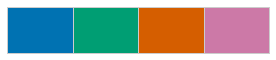

In [90]:
sns.palplot(sns.color_palette('colorblind')[0:4])

In [88]:
sns.set_color_codes(palette='deep')

/home/benjamin/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


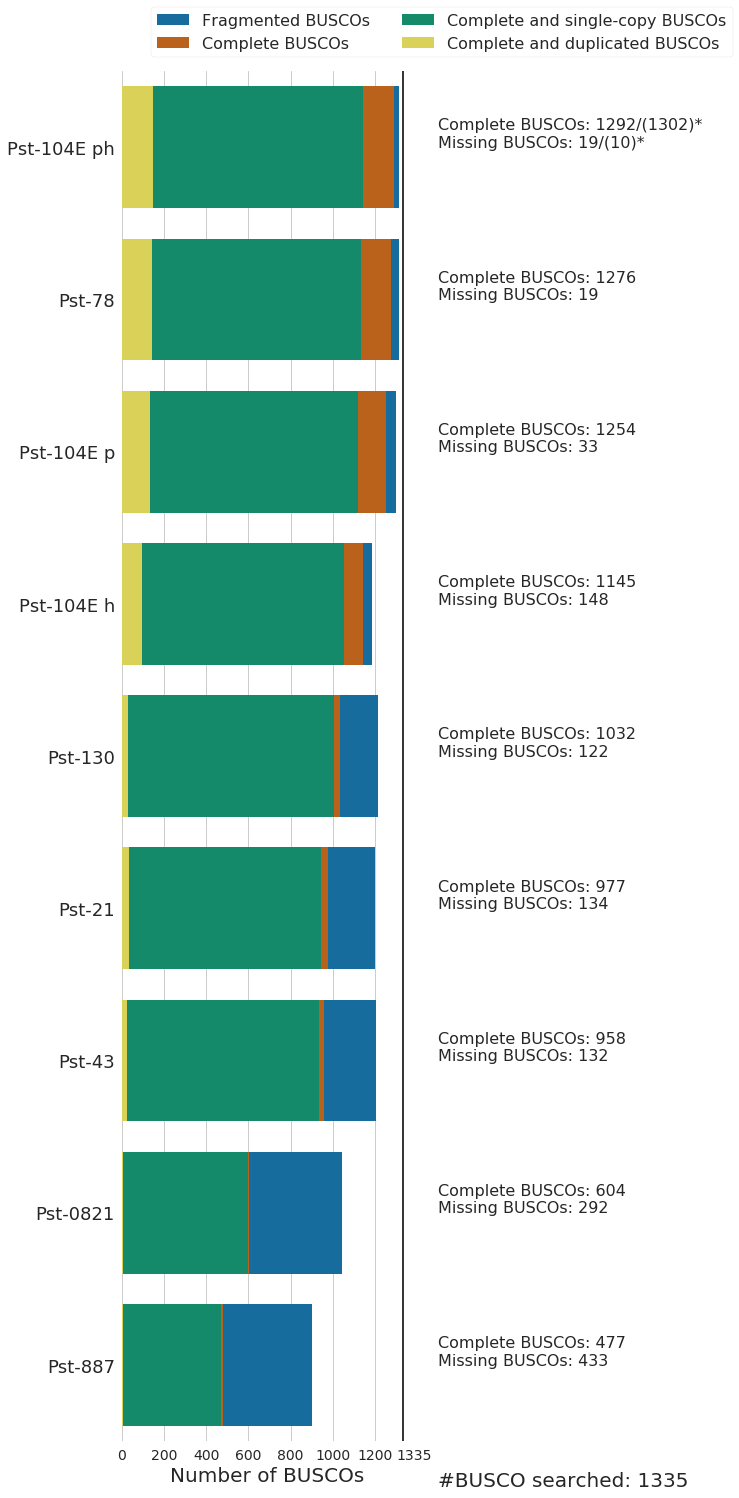

In [125]:
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(6, 20))
#set the font size 
fs = 20

sns.barplot(x='Fake Fragmented',y=SBusco_df_sorted.index, data=SBusco_df_sorted, \
            label='Fragmented BUSCOs', color=sns.color_palette('colorblind')[0],alpha=1  )

#sns.set_color_codes("pastel")
sns.barplot(x='Complete BUSCOs',y=SBusco_df_sorted.index, data=SBusco_df_sorted, \
            label='Complete BUSCOs', color=sns.color_palette('colorblind')[2],alpha=1 )

#sns.set_color_codes("muted")
sns.barplot(x='Complete and single-copy BUSCOs',y=SBusco_df_sorted.index,\
            data=SBusco_df_sorted, label='Complete and single-copy BUSCOs', \
            color=sns.color_palette('colorblind')[1], alpha=1 )

#sns.set_color_codes("pastel")
sns.barplot(x='Complete and duplicated BUSCOs',y=SBusco_df_sorted.index, \
            data=SBusco_df_sorted, label='Complete and duplicated BUSCOs', \
            color=sns.color_palette('colorblind')[4],alpha=1  )



# Add a legend and informative axis label
ax.legend(ncol=2, loc=(0.1, 1.01), frameon=True,fancybox=True, fontsize = 16)
count = 0
for y, complete, missing in zip(np.arange(0, 9, 1),SBusco_df_sorted['Complete BUSCOs'], SBusco_df_sorted['Missing BUSCOs'] ):
    if count == 0:
        ax.text(1500, y, 'Complete BUSCOs: %i/(1302)*\nMissing BUSCOs: %i/(10)*' % (complete, missing)\
           ,{'fontsize' : 16})

    else:
        ax.text(1500, y, 'Complete BUSCOs: %i\nMissing BUSCOs: %i' % (complete, missing)\
           ,{'fontsize' : 16})
    count += 1
plt.xlabel('Number of BUSCOs', {'fontsize' : fs})
plt.axvline(x=1335,  color='k')
ax.text(1500,8.8, '#BUSCO searched: 1335',{'fontsize' : fs})
#adjust the last ticks
ax.text(1300,8.62,'1335', fontsize=14)
sns.despine(left=True, bottom=True)
#add xticks as wanted
plt.xticks([0, 200,400,600,800,1000,1200] )
ax.tick_params(axis = 'y', labelsize=18)
ax.tick_params(axis = 'x', labelsize=14)
plt.savefig(os.path.join(FIGURE_FOLDER, 'Busco_summary_figure_v2.png'), dpi=600, bbox_inches="tight")